## ANTHONY-GODSWILL I'DOR' (20230)

## Importing all the relevant library needed


In [1]:
import pandas as pd
data = pd.read_csv('IMDBdataset.csv')


In [2]:
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Processing

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re


# Function to clean the data
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Lowercasing
    text = text.lower()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    
    return text




In [4]:
# Apply the function on the 'review' column
data['review'] = data['review'].apply(clean_text)

# Splitting the data
train, temp = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])  # 80% train
valid, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['sentiment'])  # 10% validation, 10% test

print(train.head())
print(valid.head())
print(test.head())

                                                  review sentiment
47808  caught little gem totally accident 1980 81 rev...  positive
20154  believe let movie accomplish favor friends ask...  negative
43069  spoiler alert just gets nerve people remake us...  negative
19413  theres thing ive learnt watching george romero...  negative
13673  remember theaters reviews said horrible didnt ...  negative
                                                  review sentiment
42623  complete waste time eighteen really wasnt swee...  negative
23391  total garbage reflection washington heights ar...  negative
49491  people writing great movie horrible acting sub...  negative
48512  phenomenon helge schneider defies easy descrip...  positive
23744  action scenes quite good plot movie score 1 10...  negative
                                                  review sentiment
46799  2 years remember complete waste comprises enti...  negative
45891  blob great horror movie merely vividly horrifi...  posi

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import re

# Convert sentiment to numerical values (assuming only 'positive' and 'negative' labels)
train['sentiment'] = train['sentiment'].map({'positive': 1, 'negative': 0})
valid['sentiment'] = valid['sentiment'].map({'positive': 1, 'negative': 0})
test['sentiment'] = test['sentiment'].map({'positive': 1, 'negative': 0})


### Modelling and Training

In [6]:

X_train, y_train = train['review'], train['sentiment']
X_valid, y_valid = valid['review'], valid['sentiment']
X_test, y_test = test['review'], test['sentiment']

# Model pipeline
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])


In [7]:

# Training the SVM model
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)



/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [8]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)


In [9]:

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(confusion)


Accuracy: 0.8968
F1 Score: 0.8970
Precision: 0.8952
Recall: 0.8988
Confusion Matrix:
[[2237  263]
 [ 253 2247]]


In [10]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments



# BERT Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_reviews(dataframe):
    return tokenizer(dataframe['review'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')


2023-09-06 19:08:40.820233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:

train_encodings = encode_reviews(train)
valid_encodings = encode_reviews(valid)
test_encodings = encode_reviews(test)

# PyTorch datasets
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [12]:

train_dataset = IMDbDataset(train_encodings, train['sentiment'].tolist())
valid_dataset = IMDbDataset(valid_encodings, valid['sentiment'].tolist())
test_dataset = IMDbDataset(test_encodings, test['sentiment'].tolist())

# Model & Training
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#!pip install accelerate -U

In [14]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Setting this to match evaluation_strategy
    logging_dir='./logs',
    logging_steps=100,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
)


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        'accuracy': accuracy_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1)),
        'f1': f1_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1)),
        'precision': precision_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1)),
        'recall': recall_score(eval_pred.label_ids, eval_pred.predictions.argmax(-1)),
    }
)


In [18]:
trainer.train()

# Evaluation
results = trainer.evaluate(test_dataset)


 [15000/15000 08:25 < 112:55:00, 2.17 it/s, Epoch 1.00/3]
Epoch	Training Loss	Validation Loss
1	0.4231	0.2736

 [15000/15000 07:33 < 113:53:45, 2.20 it/s, Epoch 2.00/3]
2	0.2180	0.2478

 [15000/15000 09:20 < 112:54:10, 2.19 it/s, Epoch 3.00/3]
3	0.1367	0.2423

Training completed.



In [19]:

print(results)


{'eval_loss': 0.2387, 'accuracy': 0.9025, 'f1': 0.9028, 'precision': 0.901, 'recall': 0.9042}


### Evaluation

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Given results
svm_results = {
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Precision': precision,
    'Recall': recall
}

bert_results = {
    'Accuracy': 0.9025,
    'F1 Score': 0.9028,
    'Precision': 0.9010,
    'Recall': 0.9042
}

# Create DataFrame for visualization
df = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'SVM': [svm_results[metric] for metric in svm_results],
    'BERT': [bert_results[metric] for metric in bert_results]
})

print(df)


     Metrics       SVM    BERT
0   Accuracy  0.896800  0.9025
1   F1 Score  0.897006  0.9028
2  Precision  0.895219  0.9010
3     Recall  0.898800  0.9042


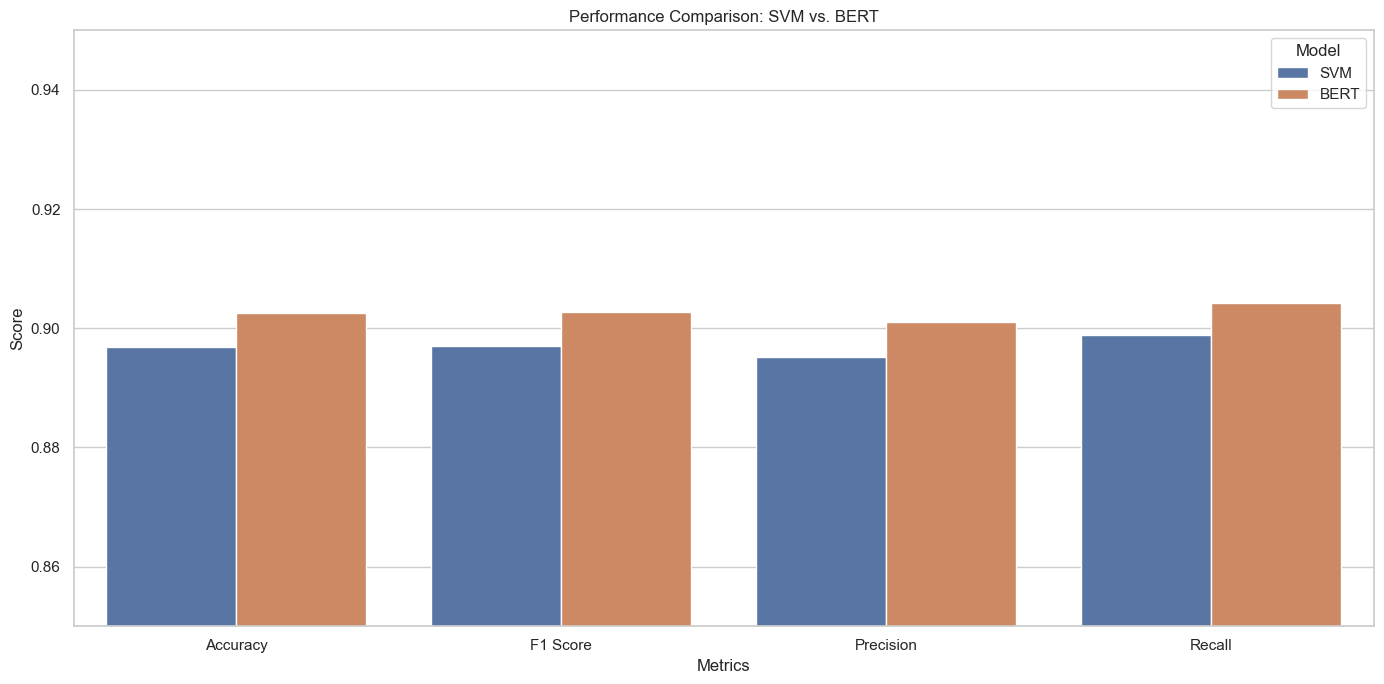

In [21]:
# Set seaborn style for visualization
sns.set_theme(style="whitegrid")

# Plot
plt.figure(figsize=(14,7))
ax = sns.barplot(data=df.melt(id_vars="Metrics", var_name="Model", value_name="Score"),
                 x="Metrics", y="Score", hue="Model")
ax.set_title("Performance Comparison: SVM vs. BERT")
ax.set_ylim(0.85, 0.95)
plt.tight_layout()
plt.show()


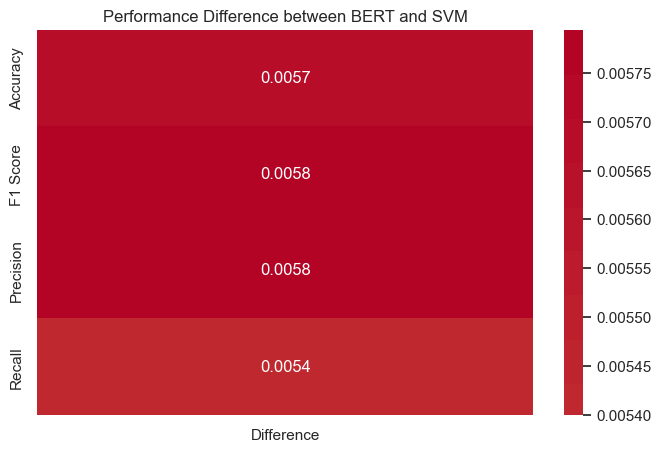

In [22]:
diff = {
    metric: bert_results[metric] - svm_results[metric] for metric in bert_results
}
df_diff = pd.DataFrame(diff, index=['Difference']).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(df_diff, annot=True, cmap='coolwarm', center=0)
plt.title('Performance Difference between BERT and SVM')
plt.show()


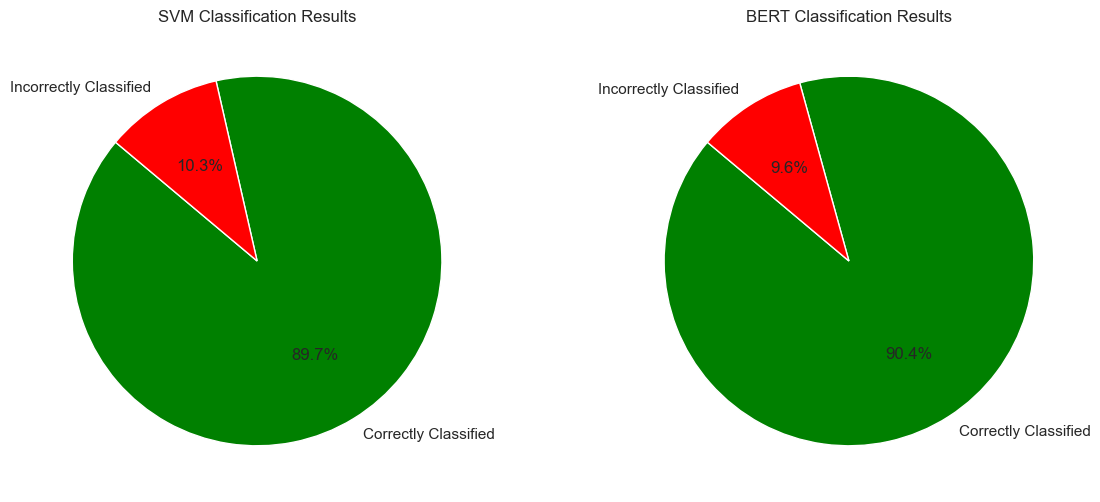

In [23]:
#  data
labels = ['Correctly Classified', 'Incorrectly Classified']
svm_counts = [4484, 516]  
bert_counts = [4520, 480]  

# SVM Pie
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.pie(svm_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'red'])
plt.title('SVM Classification Results')

# BERT Pie
plt.subplot(1, 2, 2)
plt.pie(bert_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'red'])
plt.title('BERT Classification Results')
plt.show()


#### Hyperparameter Optimization and Comparative

In [30]:
from sklearn.model_selection import GridSearchCV

# Specify the hyperparameters and their possible values
param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'clf__C': [0.1, 1, 10],
    'clf__loss': ['hinge', 'squared_hinge']
}



In [37]:
# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)




In [36]:

# Use the best estimator to make predictions
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"\nAccuracy after tuning: {accuracy:.4f}")
print(f"F1 Score after tuning: {f1:.4f}")
print(f"Precision after tuning: {precision:.4f}")
print(f"Recall after tuning: {recall:.4f}")
print("Confusion Matrix after tuning:")
print(confusion)


Accuracy after tuning: 0.9045
F1 Score after tuning: 0.9030
Precision after tuning: 0.9012
Recall after tuning: 0.9048


